In [2]:
import numpy              as np
import matplotlib.pyplot  as plt
import itea               as sr
import matplotlib.patches as patches

from sklearn.datasets import load_diabetes
from sklearn          import linear_model, datasets
from matplotlib.path  import Path
from matplotlib.lines import Line2D
from matplotlib       import rc

plt.style.use('default')
rc('text', usetex=True)

print('Done')

Done


In [9]:
# Definindo funções auxiliares que usaremos para fazer o plot de coordenadas paralelas

def parallel_plot(host, data, names, groups, legends=False):
    
    # Menores e maiores valores de cada coluna
    datamins = data.min(axis=0)
    datamaxs = data.max(axis=0)
    
    # range de cada coluna
    datadelta = datamaxs - datamins
    
    datamins -= datadelta * 0.05  # add 5% padding below and above
    datamaxs += datadelta * 0.05

    # Para inverter uma coluna, fazer como a linha abaixo com o número da coluna
    #datamaxs[1], datamins[1] = datamaxs[1], datamins[1] 
    
    datadelta = datamaxs - datamins

    # normalizando os intervalos das colunas para serem todos no mesmo valor
    zs        = np.zeros_like(data)
    zs[:, 0]  = data[:, 0]
    zs[:, 1:] = (data[:, 1:] - datamins[1:]) / datadelta[1:] * datadelta[0] + datamins[0]

    # Criando os eixos paralelos
    axes = [host] + [host.twinx() for i in range(data.shape[1] - 1)]
    
    for i, ax in enumerate(axes):
        if datamins[i] == datamaxs[i]:
            ax.set_ylim(datamins[i]*0.5, datamaxs[i]*1.5)
        else:
            ax.set_ylim(datamins[i], datamaxs[i])
            
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        
        if ax != host:
            ax.spines['left'].set_visible(False)
            ax.yaxis.set_ticks_position('right')
            ax.spines["right"].set_position(("axes", i / (data.shape[1] - 1)))

    # Ajustando o eixo principal (axs passado como 'host')
    host.set_xlim(0, data.shape[1] - 1)
    host.set_xticks(range(data.shape[1]))
    host.set_xticklabels(names, fontsize=14)
    host.tick_params(axis='x', which='major', pad=7)
    host.spines['right'].set_visible(False)
    host.xaxis.tick_bottom()
    
    legend_handles = [
        Line2D([0,1],[0,1], lw=lw, c=c, alpha=a, ls=ls)
        for _, c, a, ls, lw, label in groups
    ]
    
    for i, ((init, end), color, alpha, linestyle, linewidth, label) in enumerate(groups):
        for j in range(init, end, 1):
            if j>len(data):
                continue
                
            line = data[0, :]
            
            # curvas bezier
            verts = list(zip(
                [x for x in np.linspace(0, len(data) - 1, len(data) * 3 - 2, endpoint=True)],
                np.repeat(zs[j, :], 3)[1:-1]
            ))
            
            # path.LINETO, path.CURVE4
            codes = [Path.MOVETO] + [Path.CURVE4 for _ in range(len(verts) - 1)]
            path  = Path(verts, codes)
            patch = patches.PathPatch(
                path, facecolor='none', lw=linewidth, alpha=alpha, edgecolor=color, linestyle=linestyle,
                zorder=len(groups) - j
            )
            host.add_patch(patch)
        
    if legends:
        host.legend(
            legend_handles, [label for _, _, _, _, _, label in groups],
            loc='lower center', bbox_to_anchor=(0.5, -0.35),
            ncol=len(groups), fancybox=True, shadow=True, edgecolor=None
        )
    
    return host

def parallel_plot_term(axs, X, term, func, coeff, bias):
    print(term, func, coeff)
    
    data   = []
    groups = []
    colors = plt.cm.tab10.colors

    nsamples = len(X)//2
    # pegar cada feature por vez
    for i, t in zip(range(len(X[0])), term):

        count = 0
        # pegar amostras (para cada um, vamos fazer variável por variável):
        for j in range(nsamples):
            x = X[j][i]

            # Omitindo os que são elevados a 0
            if t!=0:
                evaluate_to = coeff*bestsol.funcList[func](np.prod(X[j]**term)) + bias
                data.append([x, t, x**t, bestsol.funcList[func](x**t), evaluate_to])
                count += 1

        # criando o grupo para essa variável
        if count >0:
            groups.append(((len(data)-count, len(data)), colors[i], 0.3, '-', 1, ynames[i]))

    data = np.array(data)
    
    return parallel_plot(
        axs, data, ['$var$', '$expn$', '$var^{expn}$', '${func}(var^{expn})$', '$Term$'],
        groups, legends=True
    )

In [3]:
# Fazendo um experimento com o dataset real "Diabetes"

data    = load_diabetes()
ynames  = data.feature_names
X, y    = data.data, data.target 

params = {
    'popsize'  : 150,
    'gens'     : 100, 
    'minterms' : 1,
    'model'    : linear_model.LinearRegression(n_jobs=-1),
    'funs'     : {
        "id"      : lambda x: x,
        "sin"     : np.sin, 
        "cos"     : np.cos,        
        "tanh"    : np.tanh,
        "sqrt.abs": lambda x: np.sqrt(np.absolute(x)),
        "log"     : np.log, 
        "exp"     : np.exp,
    },
    'expolim'  : (-2, 2),
    'maxterms' : 4,
}

itea = sr.ITEA(**params)
bestsol = itea.run(X, y, log=None, verbose=True)

gen	best fitness	mean fitness	mean length
0/100	66.39748796525072	76.34438022349569	2.5
1/100	66.39017327897942	76.03442913275806	2.7
2/100	66.39017327897942	75.6088435949166	2.74
3/100	66.39017327897942	74.75348751238019	2.7333333333333334
4/100	66.39017327897942	74.23028462432772	2.6866666666666665
5/100	66.15243534224128	73.10836343800473	2.6333333333333333
6/100	66.0632181199188	71.55579989880287	2.5933333333333333
7/100	66.0632181199188	70.24421076464218	2.546666666666667
8/100	65.85499559122573	68.70431897669856	2.7266666666666666
9/100	65.85499559122573	67.67960385471521	2.933333333333333
10/100	65.78779090898671	66.9472514885267	3.1466666666666665
11/100	65.64969738606828	66.37990177856422	3.42
12/100	65.63126628806066	66.2076838343162	3.52
13/100	65.36572181756415	66.50719179426824	3.54
14/100	65.36572181756415	66.24071504123008	3.506666666666667
15/100	65.36572181756415	65.95218500483789	3.5733333333333333
16/100	65.26758523528305	65.91332029776677	3.6533333333333333
17/100	6

In [4]:
print(bestsol)

25.382*tanh(x0^2 * x1^-2 * x2^-1 * x4^2 * x6^-2 * x7^-2 * x8^-2) + 11.427*tanh(x1^2 * x3 * x4^2 * x5^-2 * x6^-2 * x9^-2) + 28.609*tanh(x0^-2 * x1^-2 * x2^-2 * x4^-2 * x5^2 * x6^2 * x7^-2 * x8 * x9^2) + 1.394*tanh(x0^-1 * x1^-1 * x2^-2 * x3^-2 * x4^-1 * x5^2 * x6^-1 * x7 * x8 * x9) + 156.845


[5 0 2] tanh 60.6743030930749
[ 1  2 -4] tanh 22.84830925871145
[ 0 -2  3] tanh 33.38501470579221
[ 1 -2  0] tanh 17.189562862965513
[-3 -5  3] tanh -3.6143458628706986


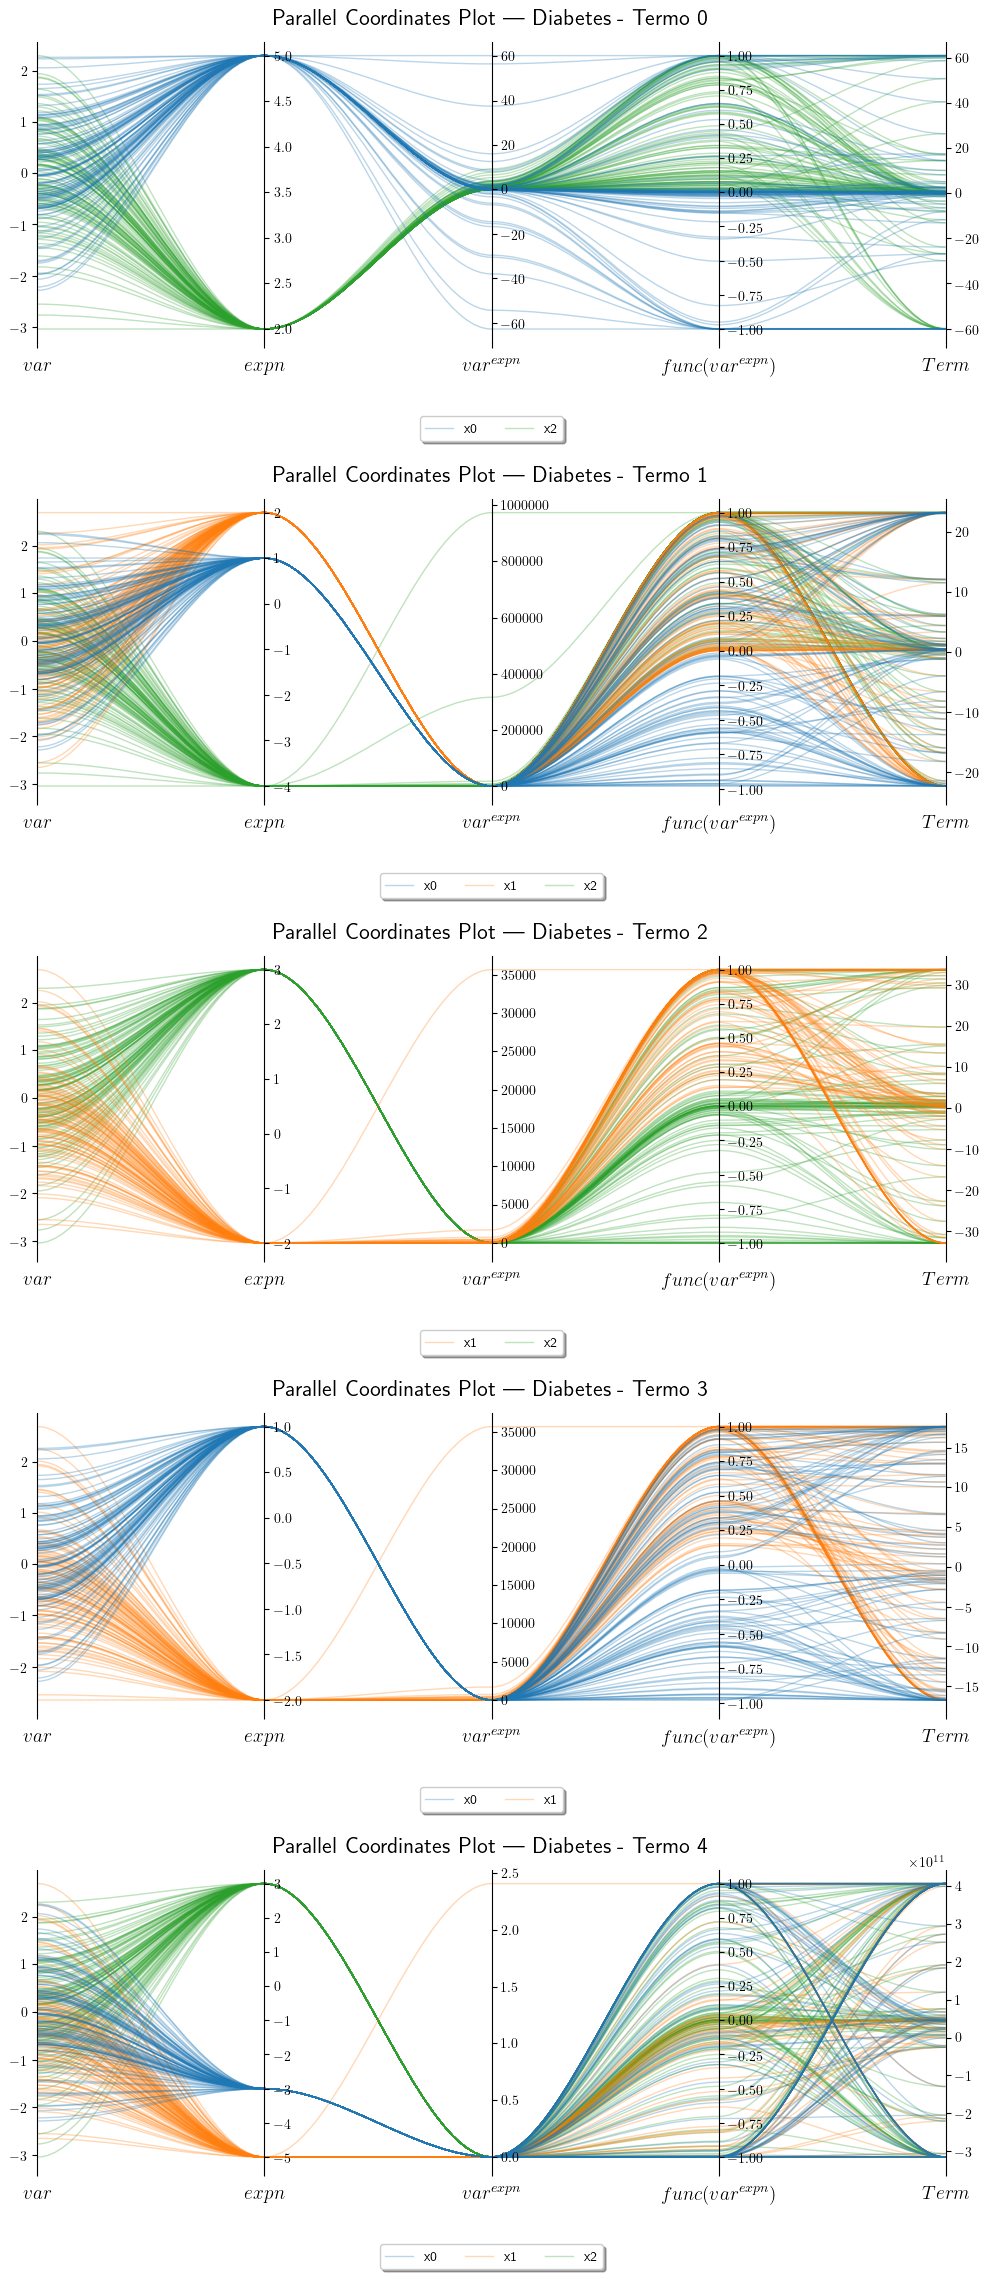

In [10]:
fig, axs = plt.subplots(nrows=len(bestsol.coeffs), ncols=1, figsize=(10,5*len(bestsol.coeffs)))
for i, ax in enumerate(fig.axes):
    ax = parallel_plot_term(ax, X, bestsol.terms[i], bestsol.funcs[i], bestsol.coeffs[i], bestsol.bias)
    ax.set_title(f'Parallel Coordinates Plot — Diabetes - Termo {i}', fontsize=16, pad=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Interpretando o plot

Todas as variáveis que tem um expoente 0, resultando em 1 (elemento neutro da multiplicação e, portanto, indiferente para o termo na hora de realizar a interação entre as variáveis) são omitidas. Note que o dataset original tem 10 variáveis, mas na legenda aparecem menos. Se olharmos o termo, vemos que temos algumas variáveis com expoente 0, então o valor que elas assumem é irrelevante.

## Primeira paralela $var$ (variáveis)

A primeira paralela separa, por cores (indicadas nas legendas), as 10 variáveis (features) do dataset de diabetes utilizado no regressor. Neste plot, não é possível parear cada uma das variáveis para obter o sample correspondente, a ideia é mostrar onde diferentes valores entram na hora de serem elevados ao seu expoente.

## Segunda paralela $expn$ (expoentes)

Como um termo IT associa, para cada variável do problema, um expoente ao qual essa variável será elevada antes da interação, a segunda paralela recebe como entrada as variáveis correspondentes. Vemos que não ocorrem todos os expoentes em alguns casos (e a variável não é modificada quando o expoente é 1), e que a maioria converge para o -2. Lembrando que $x^{-n} = \frac{1}{x^n}$, então essas variáveis viram o denominador da interação.

## Terceira paralela $var^{expn}$ (elevação das variáveis aos seus expoentes)

É a combinação do valor da primeira paralela elevado ao valor da segunda paralela, para cada variável. É possível ver que, para vários casos, as variáveis de entrada tem um valor pequeno, e elevar a expoentes maiores que 1 faz com que diminuam de valor, de forma que quase sempre cada variável vai para um valor próximo (é possível perceber isso nas linhas entre a segunda e a terceira paralela)  

## Quarta paralela $func(var^{expn})$ 

Aqui temos quase o termo IT completo - falta apenas o coeficiente e o bias. Cada variável de uma mesma amostra, ao ser elevada para seu expoente, interage com as variáveis correspondentes da amostra e então a função de transformação é aplicada. Cada amostra irá ter diferentes linhas (pois são coloridas de acordo com a variável da amostra), e então as correspondentes irão convergir para um valor avaliado pelo termo IT. É possível ver que, mesmo com vários valores das diferentes amostras, após serem elevadas ao expoentes, multiplicadas entre si e aplicada a função de transformação, não há muitos valores diferentes que a função de transformação pode assumir. 

## Quinta paralela $Term$ (Termo IT avaliado)

Faz a mesma computação que a paralela anterior, mas aqui o bias é incluído.


In [6]:
# Vamos fazer um segundo experimento, com um dataset criado artificialmente.
# Sabemos que, nesse experimento, uma das variáveis não é informativa.

ynames     = ['x0', 'x1', 'x2']
X, y, coef = datasets.make_regression(n_samples=200, n_features=3,
                                      n_informative=2, noise=5,
                                      coef=True, random_state=0)

# Vamos mudar um pouco a configuração - outro modelo, intervalo de expolim, menos funções, e mais termos.
params = {
    'popsize'  : 50,
    'gens'     : 100, 
    'minterms' : 1,
    'model'    : linear_model.Lasso(alpha=0.1),
    'funs'     : {
        "id"      : lambda x: x,
        "sin"     : np.sin, 
        "cos"     : np.cos,        
        "tanh"    : np.tanh,
        "sqrt.abs": lambda x: np.sqrt(np.absolute(x))
    },
    'expolim'  : (-5, 5),
    'maxterms' : 5,
}

itea = sr.ITEA(**params)
bestsol = itea.run(X, y, log=None, verbose=True)

gen	best fitness	mean fitness	mean length
0/100	52.64515662232465	59.94026351519747	3.32
1/100	52.26291014423344	58.650508716898614	3.86
2/100	52.26291014423344	58.01226026608143	3.82
3/100	52.26291014423344	56.50933890447757	3.88
4/100	46.1397815765002	55.2190674686947	4.08
5/100	46.13978157629575	53.406484932379115	4.14
6/100	45.669876113547694	51.97098176605248	4.3
7/100	37.71051141170598	50.64080766211535	4.7
8/100	37.71051141170598	49.118038265723975	4.76
9/100	33.24553161172426	47.252856033725784	4.72
10/100	33.24553161172426	43.675711926552054	4.6
11/100	32.15707156933042	41.41787776191696	4.6
12/100	25.873033152281472	38.70607812682809	4.64
13/100	25.849532517516817	36.79221190098513	4.7
14/100	25.78326527003362	34.07372490687712	4.8
15/100	25.78326527003362	33.4275698542335	4.78
16/100	25.783257931384966	33.36879813983041	4.64
17/100	25.783257931384966	31.73560754498893	4.74
18/100	25.65785840739086	30.15553293329979	4.66
19/100	25.65785840739086	29.25362090691708	4.7
20/100	2

60.674*tanh(x0^5 * x2^2) + 22.848*tanh(x0 * x1^2 * x2^-4) + 33.385*tanh(x1^-2 * x2^3) + 17.19*tanh(x0 * x1^-2) + -3.614*tanh(x0^-3 * x1^-5 * x2^3) + 0.455
[5 0 2] tanh 60.6743030930749
[ 1  2 -4] tanh 22.84830925871145
[ 0 -2  3] tanh 33.38501470579221
[ 1 -2  0] tanh 17.189562862965513
[-3 -5  3] tanh -3.6143458628706986


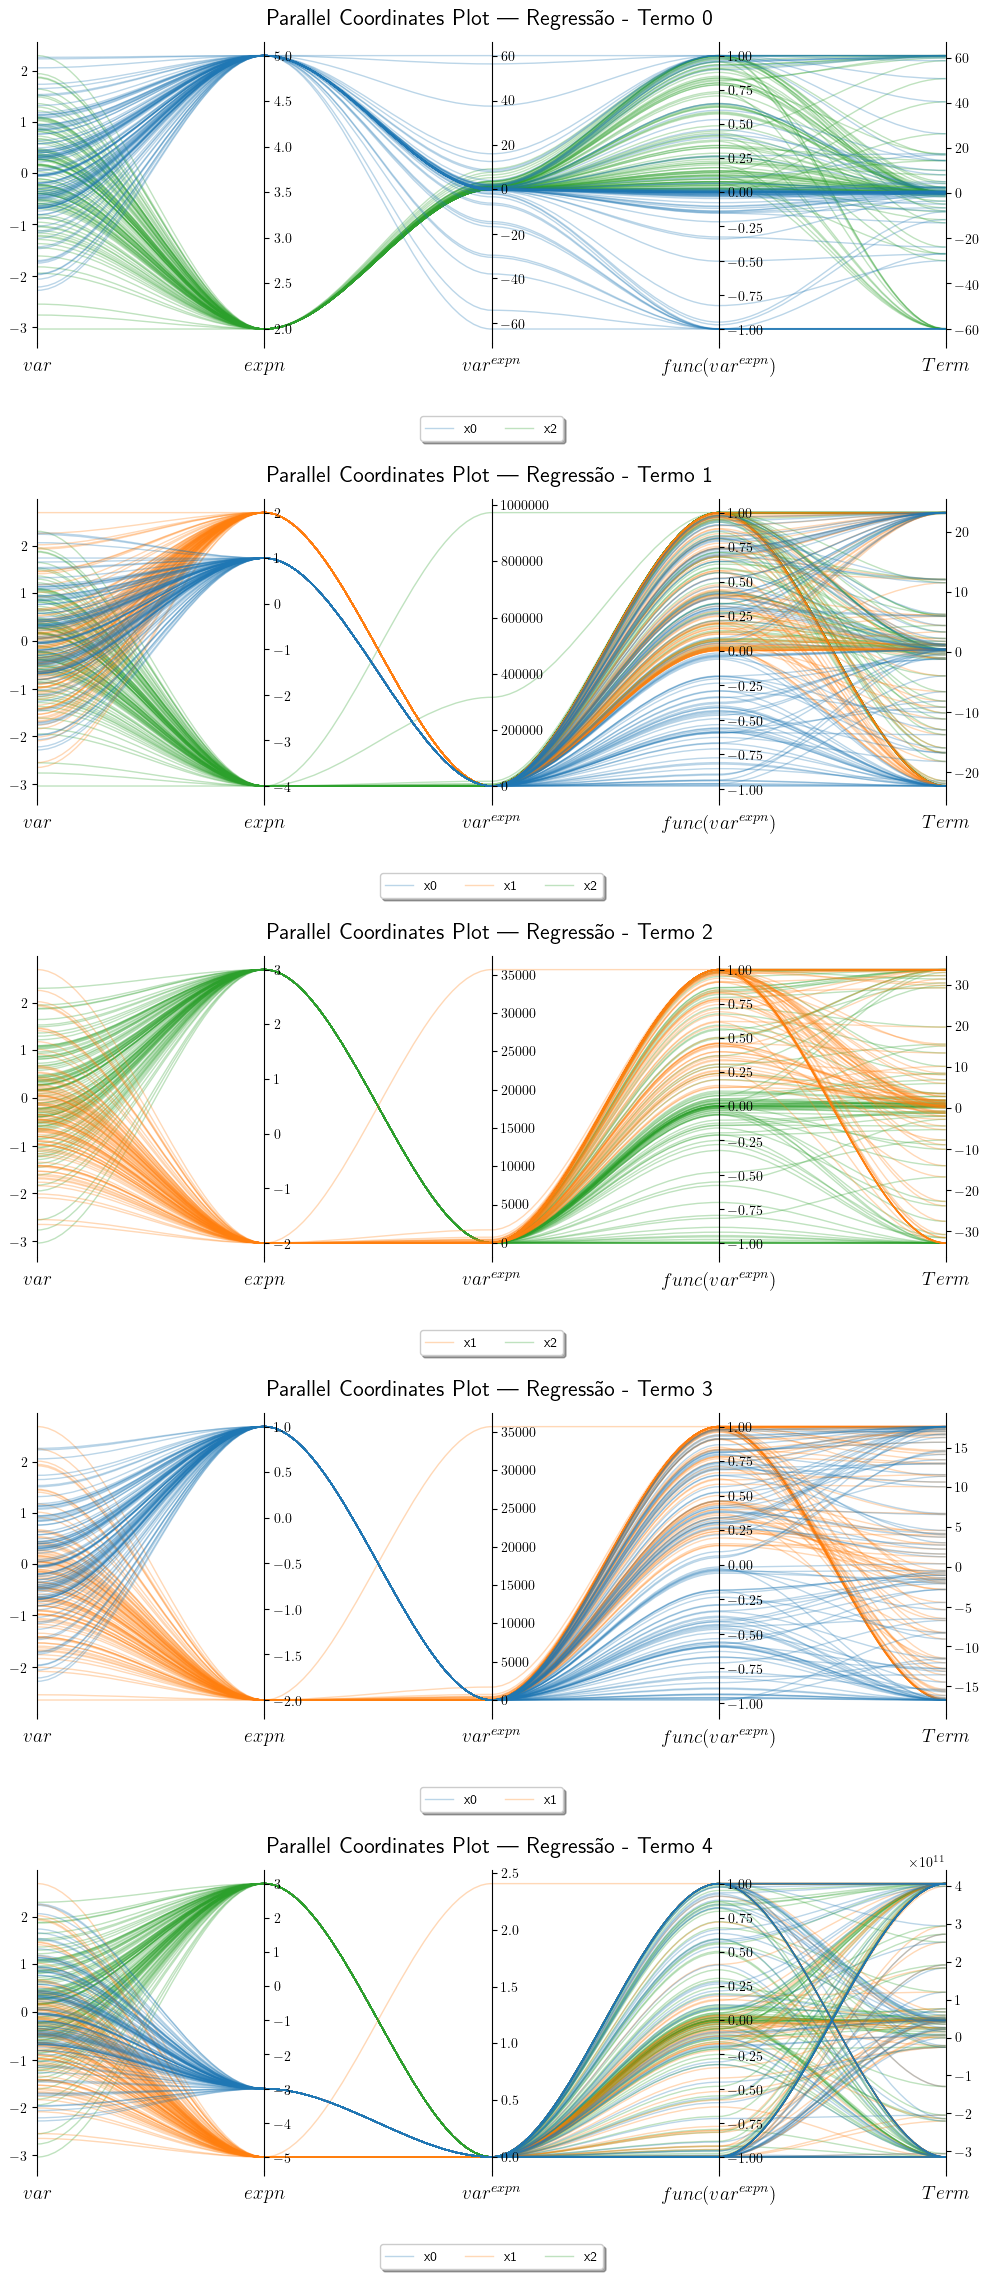

In [11]:
print(bestsol)

fig, axs = plt.subplots(nrows=len(bestsol.coeffs), ncols=1, figsize=(10,5*len(bestsol.coeffs)))
for i, ax in enumerate(fig.axes):
    ax = parallel_plot_term(ax, X, bestsol.terms[i], bestsol.funcs[i], bestsol.coeffs[i], bestsol.bias)
    ax.set_title(f'Parallel Coordinates Plot — Regressão - Termo {i}', fontsize=16, pad=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [8]:
# TODO: Verificar o porquê não plota linhas entre as 3 primeiras quando só há 1 expoente diferente de zero